In [153]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from PIL import Image, ImageEnhance
import cv2

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [154]:
# importing dataset
DATADIR = "/kaggle/input/acrima-8020/db/Training"
CATEGORIES = ["Normal", "Glaucomatous"]

IMG_SIZE = 256

training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
                img_array = cv2.imread(os.path.join(path, img), cv2.COLOR_RGB2BGR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])

create_training_data()

shuffle(training_data)

# data augmentation
data_augmentation = Sequential([
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(factor=0.1), # ±10deg
    RandomContrast(factor=0.1),
    RandomTranslation(height_factor=.15, width_factor=.15, fill_mode='wrap')
])

X = []
y = []

def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img

for features, label in training_data:
    # applying HE enhancement on each image
    features = hisEqulColor(features)
    X.append(features)
    y.append(label)

N = len(X)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

100%|██████████| 316/316 [00:02<00:00, 152.28it/s]


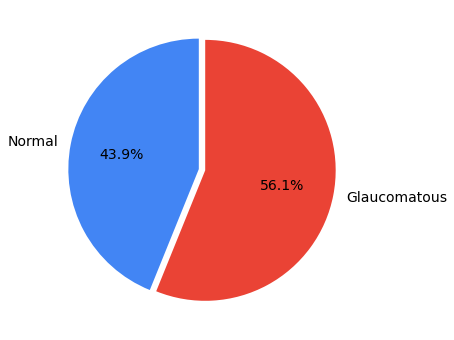

In [155]:
# plotting training dataset
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335']
plt.rcParams.update({'font.size': 14})
plt.pie([list(y).count(0), list(y).count(1)],
        labels=CATEGORIES,
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=90);

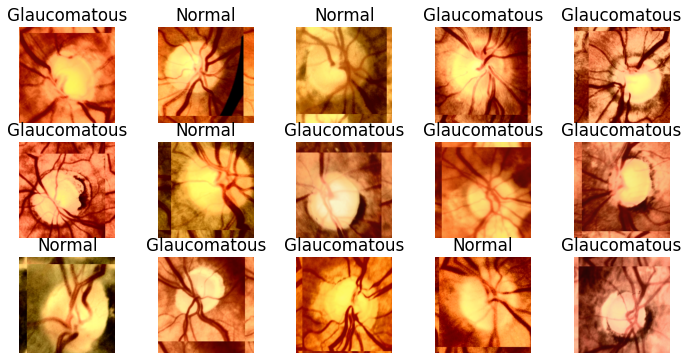

In [156]:
# plotting random images from dataset
fig = plt.figure(figsize=(12, 6))
for x in range(1, 16):
    fig.add_subplot(3, 5, x)
    plt.axis('off')
    i = random.randint(0, N-1)
    plt.title(CATEGORIES[y[i]])
    plt.imshow(data_augmentation(X[i][:, :, ::-1]))
plt.rcParams.update({'font.size': 12})
plt.show()

In [157]:
# creating neural network model
base_model = resnet50.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dense(IMG_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (256, 256, 3)             0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33554688  
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 57,142,914
Trainable params: 34,609,922
Non-trainable params: 22,532,992
________________________________

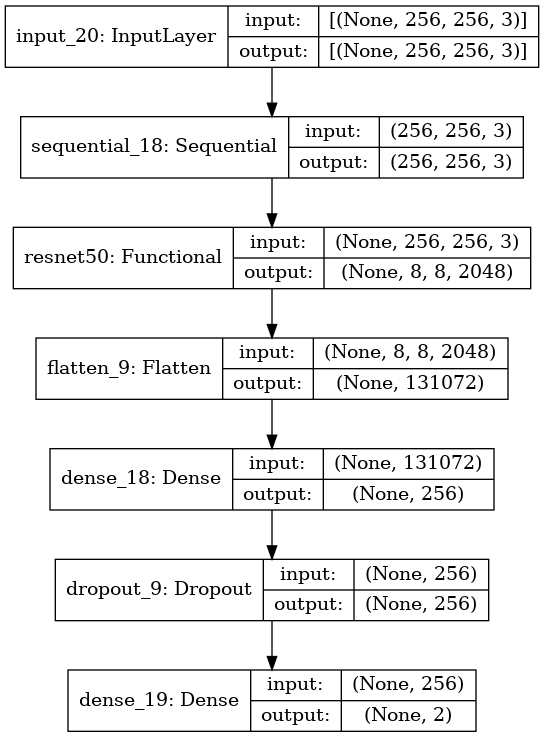

In [158]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [159]:
# training the model
batch_size = 32
epochs = 128
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/128
15/15 [==============================] - 6s 206ms/step - loss: 2.1717 - accuracy: 0.6381 - val_loss: 2.8833 - val_accuracy: 0.2471
Epoch 2/128
15/15 [==============================] - 1s 97ms/step - loss: 0.8253 - accuracy: 0.7259 - val_loss: 1.1049 - val_accuracy: 0.5059
Epoch 3/128
15/15 [==============================] - 1s 97ms/step - loss: 0.4207 - accuracy: 0.8201 - val_loss: 0.8257 - val_accuracy: 0.6118
Epoch 4/128
15/15 [==============================] - 1s 99ms/step - loss: 0.3935 - accuracy: 0.8347 - val_loss: 0.6917 - val_accuracy: 0.7294
Epoch 5/128
15/15 [==============================] - 1s 97ms/step - loss: 0.3623 - accuracy: 0.8347 - val_loss: 0.7270 - val_accuracy: 0.6471
Epoch 6/128
15/15 [==============================] - 1s 97ms/step - loss: 0.3156 - accuracy: 0.8494 - val_loss: 0.6185 - val_accuracy: 0.7529
Epoch 7/128
15/15 [==============================] - 1s 97ms/step - loss: 0.2813 - accuracy: 0.8682 - val_loss: 0.4972 - val_accuracy: 0.7765
Epoch

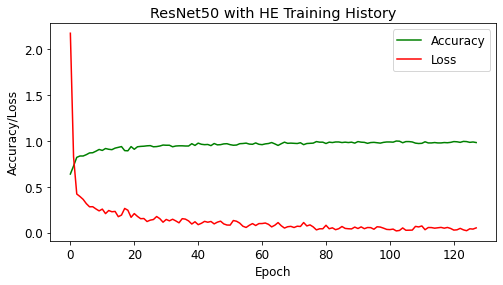

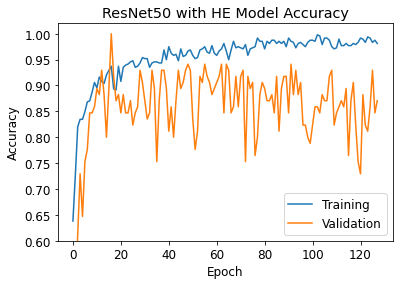

In [160]:
# plotting training history
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], 'g-')
plt.plot(history.history['loss'], 'r-')
plt.title('ResNet50 with HE Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.savefig('training_history', dpi=300)
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 with HE Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('model_accuracy', dpi=300)
ax = plt.gca()
ax.set_ylim([.6, 1.02])
plt.show()

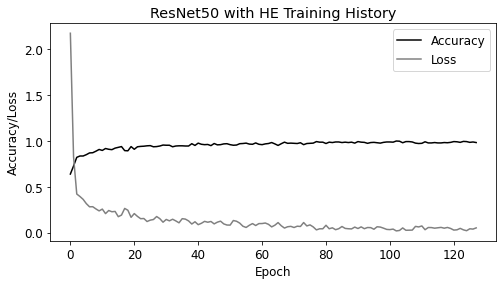

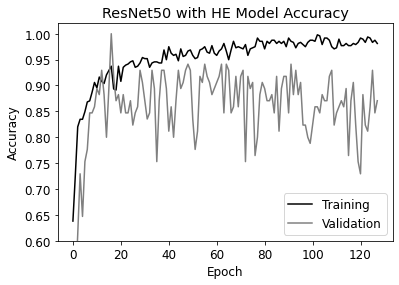

In [161]:
# plotting training history
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], 'k-')
plt.plot(history.history['loss'], '-', color='gray')
plt.title('ResNet50 with HE Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.savefig('training_history.jpg', dpi=300)
plt.show()

plt.plot(history.history['accuracy'], 'k-')
plt.plot(history.history['val_accuracy'], '-', color='gray')
plt.title('ResNet50 with HE Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('model_accuracy.jpg', dpi=300)
ax = plt.gca()
ax.set_ylim([.6, 1.02])
plt.show()

In [162]:
# importing dataset
TESTING_DATADIR = "/kaggle/input/acrima-8020/db/Testing"

testing_data = []

def create_testing_data():
    for category in CATEGORIES:

        path = os.path.join(TESTING_DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
                img_array = cv2.imread(os.path.join(path, img), cv2.COLOR_RGB2BGR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])

create_testing_data()

testX = []
testy = []

for features, label in testing_data:
    # applying HE enhancement on each image
    features = hisEqulColor(features)
    testX.append(features)
    testy.append(label)

testX = np.array(testX).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
testy = np.array(testy)

100%|██████████| 80/80 [00:00<00:00, 160.18it/s]


In [163]:
y_pred = []
y_true = testy

probas = model.predict(testX)
y_pred = np.argmax(probas, axis=-1)

print(classification_report(y_true, y_pred, target_names=CATEGORIES))

              precision    recall  f1-score   support

      Normal       0.92      0.95      0.94        62
Glaucomatous       0.96      0.94      0.95        80

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142



Accuracy: 0.9436619718309859
Sensitivity, Recall, True Positive Rate: 0.9375
Specificity, Selectivity, True Negative Rate: 0.9516129032258065
Precision, Positive Predictive Value: 0.9615384615384616
Negative Predictive Value: 0.921875
Dice Similarity Coefficient, F1 Score: 0.9493670886075949


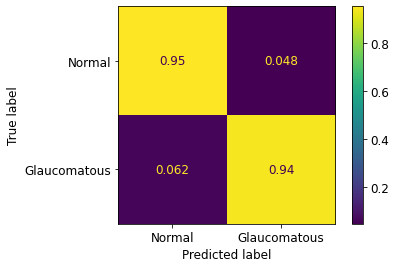

In [164]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# positive refers to presence of glaucoma, while negative refers to a normal image

sen = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / ( tn + fp + fn + tp)
# auc = roc_auc_score(y_true, y_pred) #  area under receiver operating characteristics curve
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
dsc = 2 * tp / (2 * tp + fp + fn)

print("Accuracy:", acc)
print("Sensitivity, Recall, True Positive Rate:", sen)
print("Specificity, Selectivity, True Negative Rate:", sp)
print("Precision, Positive Predictive Value:", ppv)
print("Negative Predictive Value:", npv)
# print("Area Under the ROC Curve:", auc)
print("Dice Similarity Coefficient, F1 Score:", dsc)

cm = confusion_matrix(y_true, y_pred, normalize='all')
CATEGORIES = ["Normal", "Glaucomatous"]
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
cmd = ConfusionMatrixDisplay.from_estimator(IC, y_pred, y_true, normalize='true', display_labels=CATEGORIES)
cmd.figure_.savefig('confusion_matrix.jpg', dpi=300)

Area Under the ROC Curve: 0.9909274193548387


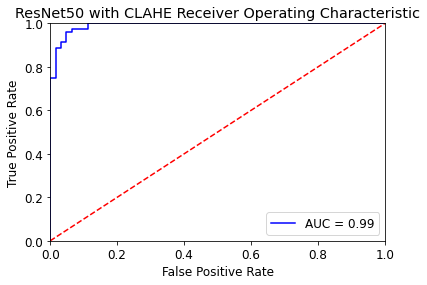

In [165]:
fpr, tpr, threshold = roc_curve(y_true, probas[:, 1])
roc_auc = auc(fpr, tpr)

print("Area Under the ROC Curve:", roc_auc)

plt.title('ResNet50 with CLAHE Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [166]:
# model.save(f'glaucoma-fundus-rn50-acc{acc}-auc{roc_auc}.h5')

In [167]:
print(list(y_true))
print(list(y_pred))
print(list(probas[:, 1]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4.5976745e-07, 0.8813071, 1.9977563e-14, 1.595958e-11, 5.681745e-16, 2.4792393e-05, 1.6622166e-15, 0.0013774235, 1.3881601e-09, 1.13564824e-10, 2